In [2]:

# preamble
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelBinarizer
import seaborn as sns
from sklearn.decomposition import PCA

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

import nilearn as ni
from nilearn import plotting as nplt
import nibabel as nib
import networkx as nx

# Preparing dataset for classification

0    791
4    146
Name: diag, dtype: int64
Data shape original (937, 3)
0    791
4    146
Name: diag, dtype: int64
Data shape after (937, 2)
Data shape after removing features with high correlation (937, 2)


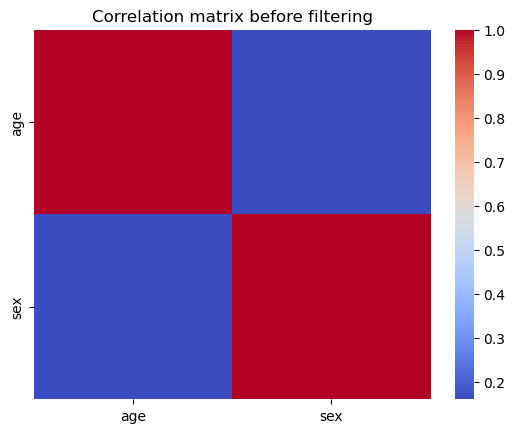

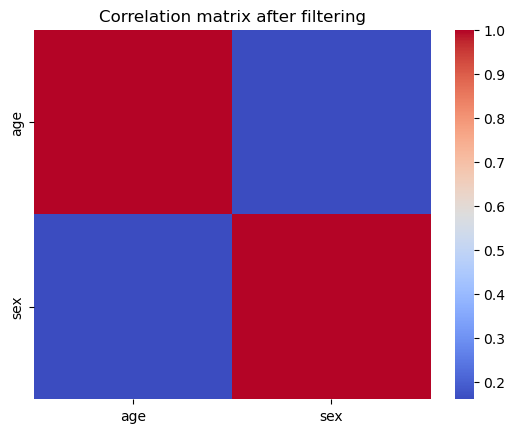

In [4]:
## 1. Load data
df = pd.read_csv('/work3/khma/SRPBS_OPEN/Data_info_files/participants.tsv', sep = '\t')
# drop sub-0889 from dataframe due to missing data
df = df.drop(df.index[df.participant_id == 'sub-0889']).reset_index(drop=True)
# extract data for schizophrenia and healthy controls
df = df[df.diag.isin([0,4])] # = df_schizo_healthy
print(df.diag.value_counts())
used_cols = ['diag','age', 'sex']
df = df[used_cols] 
print('Data shape original', df.shape)
## 2. Check for missing values and remove them if any:
df.isna().sum()
df.dropna(inplace=True)
print(df.diag.value_counts()) # what subject was removed due to NaN???

## 3. Split the data into features and target variables:
target_var = 'diag' # variable to be predicted
y = df[target_var]#.to_numpy()
used_feat = ['age', 'sex']
X = df[used_feat] 
#X = df.drop([target_var, 'participant_id'], axis=1)
print('Data shape after', X.shape)

# 4. Binarize potential binary features (in this case diag and sex)
#[len(X[feature].unique()) for feature in X.columns.to_list()]
lb = LabelBinarizer()
lb.fit_transform(X.sex)
lb.fit_transform(y)
#X['hand'] = lb.fit_transform(X['hand'])

# 5. Convert categorical variables to numerical using one-hot encoding:
#feat_to_encode = ['site', 'protocol', 'hand', 'sup']
#X = pd.get_dummies(X, columns=feat_to_encode)
#print('Data shape after using one-hot encodings', X.shape)

# 6. Feature selection based on correlation analysis
# Compute pairwise correlation coefficients
corr_matrix = X.corr()

# Visualize the correlation matrix using a heatmap
plt.figure()
sns.heatmap(corr_matrix, cmap='coolwarm')
plt.title('Correlation matrix before filtering')

# Set a correlation threshold
threshold = 0.7

# create mask to select upper triangle of correlation matrix
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# create dataframe of feature pairs with correlation greater than 0.7
high_corr_pairs = corr_matrix.mask(mask).stack().reset_index()
high_corr_pairs.columns = ['feature_1', 'feature_2', 'correlation']
high_corr_pairs = high_corr_pairs[high_corr_pairs['correlation'] > threshold]
high_corr_feat = list(set(high_corr_pairs['feature_1']).union(set(high_corr_pairs['feature_2'])))

X = X.drop(columns=high_corr_feat)
print('Data shape after removing features with high correlation', X.shape)
plt.figure()
sns.heatmap(X.corr(), cmap='coolwarm')
plt.title('Correlation matrix after filtering')

# 7. Split the data into training and test sets:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 8. Scale the data using StandardScaler:
continous_feat = ['age'] # only continous columns should be standardized (binary columns are already per definition standardized)
scaler = StandardScaler()
X_train[continous_feat] = scaler.fit_transform(X_train[continous_feat])
X_test[continous_feat] = scaler.transform(X_test[continous_feat])


## PCA
not sure its needed

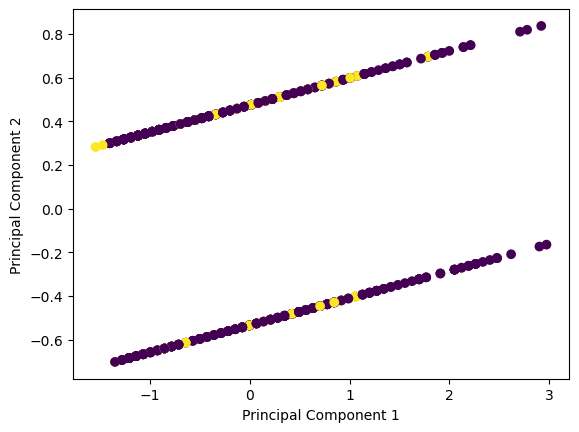

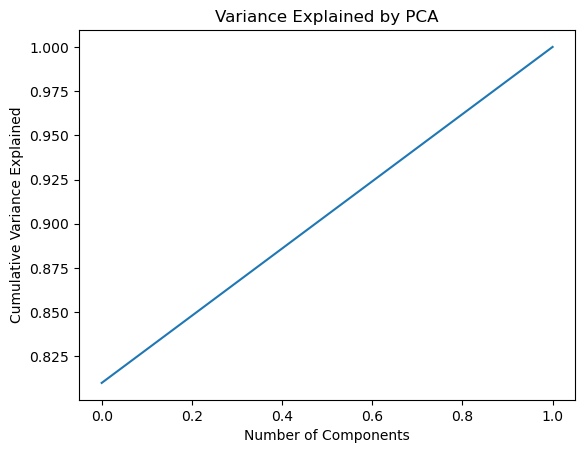

In [8]:
# Determining the number of features to use for prediction 
# PCA
pca = PCA(n_components=X_train.shape[1])
X_pca = pca.fit_transform(X_train)

plt.figure()
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Calculate the cumulative explained variance ratio
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

plt.figure()
plt.plot(cumulative_variance_ratio)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance Explained')
plt.title('Variance Explained by PCA')
plt.show()

# Find the number of components that explain 90% of the variance
n_components = np.argmax(cumulative_variance_ratio >= 0.9) + 1

# Classification using demographic information

In [5]:
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

X_train shape: (655, 2)
X_test shape: (282, 2)
y_train shape: (655,)
y_test shape: (282,)


In [6]:
y_train.value_counts() # high class imbalance

0    556
4     99
Name: diag, dtype: int64

In [7]:
X_train.sex.value_counts()

1    348
2    307
Name: sex, dtype: int64

### Logistic regression

Text(0.5, 1.0, 'Accuracy Score: 0.8333333333333334')

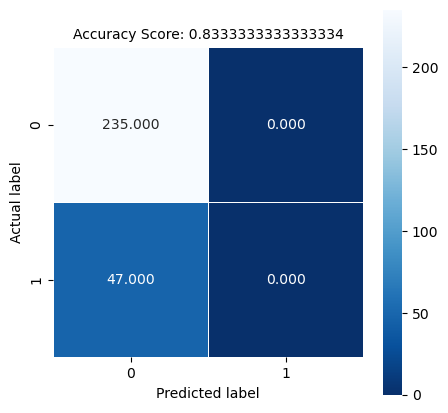

In [9]:
logisticRegr = LogisticRegression()
logisticRegr.fit(X_train, y_train)

# predict on entire test data
y_pred = logisticRegr.predict(X_test)

# Use score method to get accuracy of model
score = logisticRegr.score(X_test, y_test)
#print(score)

# confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)
#print(cm)

plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Accuracy Score: {0}'.format(score), size = 10)

### Random forest

Text(0.5, 1.0, 'Accuracy Score: 0.8156028368794326')

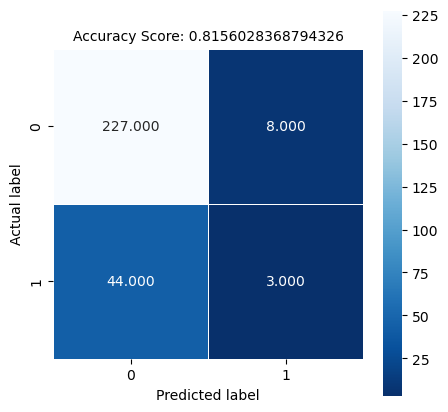

In [10]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

# predict
y_pred = rfc.predict(X_test)

# accuracy score
score = rfc.score(X_test, y_test)
#print('Accuracy:', score)

# confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)
#print(cm)

plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Accuracy Score: {0}'.format(score), size = 10)

### KNN

Text(0.5, 1.0, 'Accuracy Score: 0.7801418439716312')

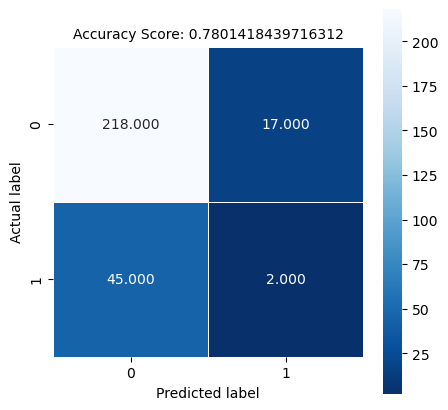

In [11]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

# predict
y_pred = knn.predict(X_test)

# accuracy score
score = knn.score(X_test, y_test)
#print('Accuracy:', score)

# confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)
#print(cm)

plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title('Accuracy Score: {0}'.format(score), size = 10)

# Classification using demographic information and eta

In [15]:
main_dir = os.getcwd()
exp_name = 'nonparametric_schaefer100_2023-04-27 19:03:50.571321'
sample = np.load(main_dir+'/results/decnef/'+exp_name+'/model_sample.npy', allow_pickle=True).item()
MAP_sample = sample['MAP']
Z = MAP_sample['Z']
noc = MAP_sample['noc']
eta = MAP_sample['eta']

In [16]:
eta.shape

(46, 46, 937)

In [18]:
X.shape

(937, 2)

In [ ]:
# combining demographic features and eta: 
# we 2 demographic features (sex and age) and the upper triangular part of eta (eta is symmetric), so in totall we will have 2+1081=1083 features

In [19]:
def get_x_data(eta):
    eta_triu_list = []
    for s in range(eta.shape[-1]):
        eta_triu_mat = np.triu(eta[:,:,s])
        eta_triu_vec = eta_triu_mat[np.triu_indices(eta_triu_mat.shape[-1])]
        eta_triu_list.append(eta_triu_vec)
    return np.array(eta_triu_list) # shape: n_samles x n_features

In [20]:
x_data = get_x_data(eta)

In [21]:
x_data.shape

(937, 1081)

In [26]:
# testing (not right, because we need to find out why the last subject is missing)
X_new = pd.DataFrame(np.concatenate((x_data,X),axis=1), columns=['eta'+str(i) for i in range(x_data.shape[1])]+list(X.columns))

In [27]:
X_new

,eta0,eta1,eta2,eta3,eta4,eta5,eta6,eta7,eta8,eta9,...,eta1073,eta1074,eta1075,eta1076,eta1077,eta1078,eta1079,eta1080,age,sex
0,0.001147,0.001086,0.000550,0.001445,0.001649,0.001050,0.001340,0.001016,0.000890,0.001644,...,0.001388,0.001097,0.001064,0.000488,0.001661,0.001064,0.000514,0.001064,23.0,1.0
1,0.001147,0.000940,0.000837,0.001590,0.001506,0.001281,0.000998,0.001081,0.001830,0.001085,...,0.001400,0.001466,0.001101,0.000617,0.000811,0.001101,0.000769,0.001101,23.0,2.0
2,0.001172,0.001254,0.001368,0.001355,0.001007,0.001328,0.001294,0.001160,0.000127,0.001278,...,0.001172,0.001288,0.001101,0.000729,0.000702,0.001101,0.001243,0.001101,26.0,1.0
3,0.001168,0.001026,0.001440,0.001304,0.001203,0.001133,0.001240,0.001170,0.000234,0.001344,...,0.001453,0.000639,0.001027,0.000471,0.001211,0.001027,0.000733,0.001027,23.0,1.0
4,0.001093,0.001126,0.001157,0.001069,0.001316,0.001111,0.001101,0.001077,0.001130,0.001089,...,0.001161,0.000919,0.001063,0.000825,0.001011,0.001063,0.001106,0.001063,24.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
932,0.001094,0.001288,0.000571,0.000966,0.000318,0.001292,0.001218,0.000783,0.001524,0.000886,...,0.001167,0.001015,0.001083,0.001621,0.000586,0.001083,0.000997,0.001083,40.0,1.0
933,0.000948,0.000873,0.001334,0.001141,0.001228,0.001106,0.000803,0.000964,0.000604,0.001580,...,0.000602,0.000440,0.000969,0.000444,0.000969,0.000969,0.000942,0.000969,31.0,2.0
934,0.000995,0.001021,0.001303,0.001310,0.001419,0.001091,0.001146,0.001034,0.000941,0.001349,...,0.001461,0.000827,0.001054,0.001945,0.000898,0.001054,0.001102,0.001054,37.0,1.0
935,0.001142,0.001355,0.001090,0.000751,0.000650,0.000970,0.001135,0.001160,0.000854,0.001504,...,0.000631,0.001363,0.001062,0.001387,0.000902,0.001062,0.000869,0.001062,20.0,2.0


In [47]:
X_new.shape

(936, 1083)

Data shape after removing features with high correlation (937, 2)


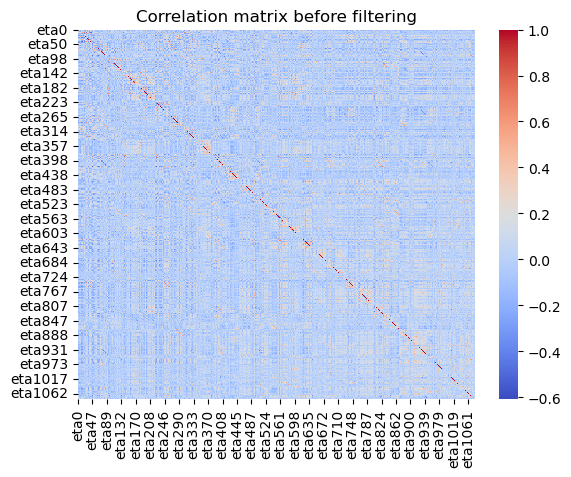

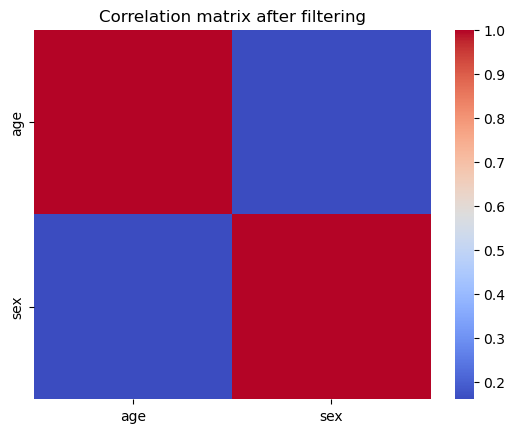

In [51]:
# 6. Feature selection based on correlation analysis
# Compute pairwise correlation coefficients
corr_matrix = X_new.corr()

# Visualize the correlation matrix using a heatmap
plt.figure()
sns.heatmap(corr_matrix, cmap='coolwarm')
plt.title('Correlation matrix before filtering')

# Set a correlation threshold
threshold = 0.7

# create mask to select upper triangle of correlation matrix
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# create dataframe of feature pairs with correlation greater than threshold
high_corr_pairs = corr_matrix.mask(mask).stack().reset_index()
high_corr_pairs.columns = ['feature_1', 'feature_2', 'correlation']
high_corr_pairs = high_corr_pairs[np.abs(high_corr_pairs['correlation']) > threshold]
high_corr_feat = list(set(high_corr_pairs['feature_1']).union(set(high_corr_pairs['feature_2'])))

X_new = X_new.drop(columns=high_corr_feat)
print('Data shape after removing features with high correlation', X.shape)
plt.figure()
sns.heatmap(X.corr(), cmap='coolwarm')
plt.title('Correlation matrix after filtering')

# 7. Split the data into training and test sets:
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.3, random_state=42)

# 8. Scale the data using StandardScaler:
continous_feat = ['age'] # only continous columns should be standardized (binary columns are already per definition standardized)
scaler = StandardScaler()
X_train[continous_feat] = scaler.fit_transform(X_train[continous_feat])
X_test[continous_feat] = scaler.transform(X_test[continous_feat])


<Axes: >

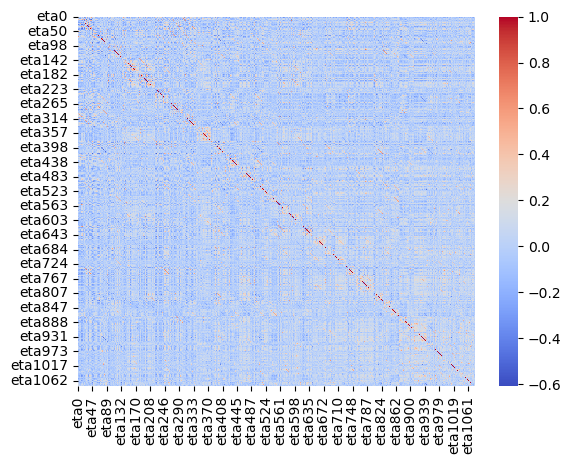

In [54]:
sns.heatmap(corr_matrix, cmap='coolwarm')

In [36]:
X_train

,eta0,eta1,eta2,eta3,eta4,eta5,eta6,eta7,eta8,eta9,...,eta1073,eta1074,eta1075,eta1076,eta1077,eta1078,eta1079,eta1080,age,sex
757,0.001122,0.000922,0.001257,0.001177,0.001666,0.001202,0.001044,0.001156,0.000606,0.001412,...,0.001458,0.001002,0.001046,0.001154,0.000678,0.001046,0.001217,0.001046,2.428295,2.0
693,0.000896,0.001062,0.000912,0.000978,0.001103,0.000804,0.000621,0.000955,0.001625,0.000693,...,0.001468,0.001635,0.001076,0.001730,0.001558,0.001076,0.002298,0.001076,-0.504816,2.0
854,0.000942,0.001009,0.000871,0.000972,0.001453,0.000806,0.001125,0.000889,0.001771,0.000813,...,0.001387,0.000474,0.001062,0.001836,0.000577,0.001062,0.000750,0.001062,-1.220209,1.0
501,0.001170,0.000753,0.001642,0.001119,0.000417,0.001397,0.001017,0.001213,0.000330,0.001243,...,0.001086,0.001098,0.001066,0.000939,0.000687,0.001066,0.001463,0.001066,-1.220209,1.0
664,0.000953,0.000954,0.001262,0.001342,0.001375,0.001099,0.000985,0.000856,0.000801,0.000962,...,0.001449,0.000545,0.001014,0.000690,0.000989,0.001014,0.000608,0.001014,-0.147120,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,0.001121,0.001285,0.001236,0.000548,0.000677,0.000865,0.001053,0.001207,0.001384,0.000330,...,0.001004,0.001358,0.001047,0.001155,0.001112,0.001047,0.000506,0.001047,-0.576356,1.0
270,0.001156,0.001088,0.001440,0.001500,0.001565,0.001359,0.001200,0.001231,0.000742,0.001870,...,0.001061,0.001157,0.000985,0.001576,0.001193,0.000985,0.000476,0.000985,-0.147120,1.0
860,0.001003,0.001185,0.000667,0.000719,0.000930,0.000814,0.001045,0.001117,0.001291,0.000896,...,0.001474,0.001020,0.001097,0.001965,0.000592,0.001097,0.001004,0.001097,-0.934052,1.0
435,0.001150,0.001333,0.001376,0.001189,0.001316,0.001419,0.001000,0.001075,0.000416,0.001934,...,0.000925,0.000820,0.001035,0.000812,0.000781,0.001035,0.000737,0.001035,-0.790973,2.0


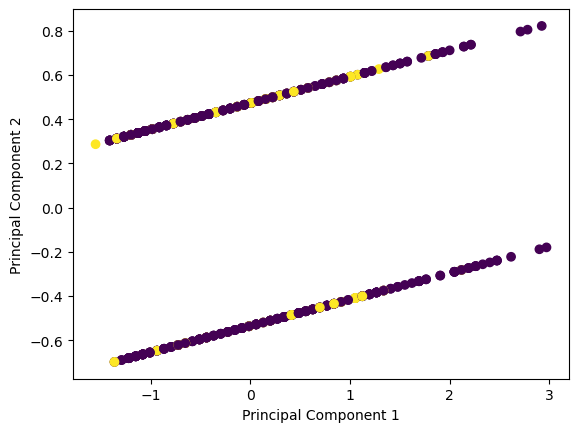

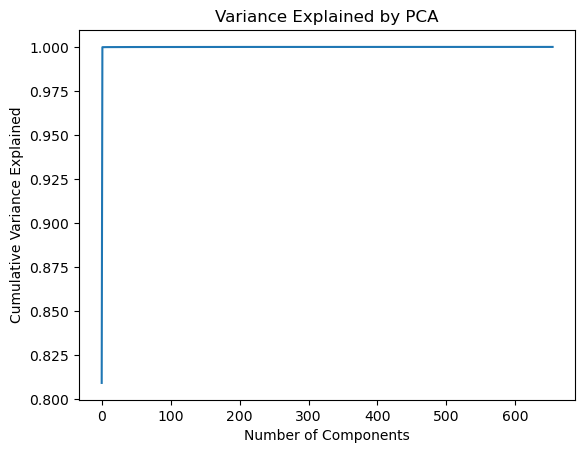

In [47]:
# Determining the number of features to use for prediction 
# PCA
pca = PCA()
X_pca = pca.fit_transform(X_train)

plt.figure()
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Calculate the cumulative explained variance ratio
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

plt.figure()
plt.plot(cumulative_variance_ratio)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance Explained')
plt.title('Variance Explained by PCA')
plt.show()

# Find the number of components that explain 90% of the variance
n_components = np.argmax(cumulative_variance_ratio >= 0.9) + 1

### Logistic regression

Text(0.5, 1.0, 'Accuracy Score: 0.8333333333333334')

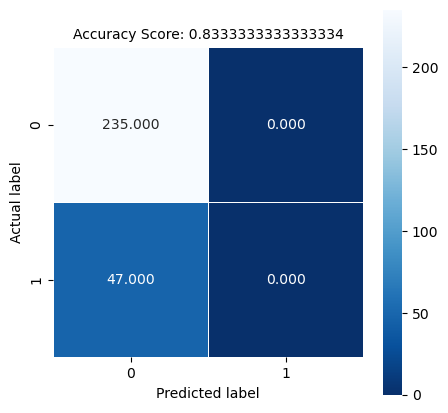

In [29]:
logisticRegr = LogisticRegression()
logisticRegr.fit(X_train, y_train)

# predict on entire test data
y_pred = logisticRegr.predict(X_test)

# Use score method to get accuracy of model
score = logisticRegr.score(X_test, y_test)
#print(score)

# confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)
#print(cm)

plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Accuracy Score: {0}'.format(score), size = 10)

### Random forest

Text(0.5, 1.0, 'Accuracy Score: 0.8333333333333334')

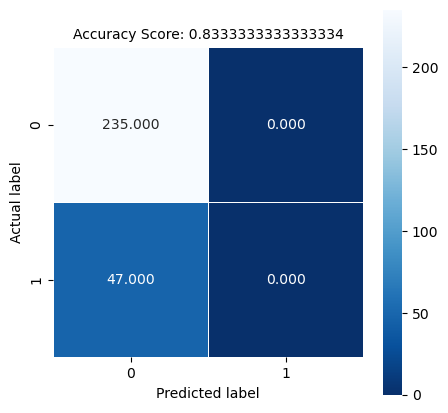

In [31]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

# predict
y_pred = rfc.predict(X_test)

# accuracy score
score = rfc.score(X_test, y_test)
#print('Accuracy:', score)

# confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)
#print(cm)

plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Accuracy Score: {0}'.format(score), size = 10)

### KNN

Text(0.5, 1.0, 'Accuracy Score: 0.8156028368794326')

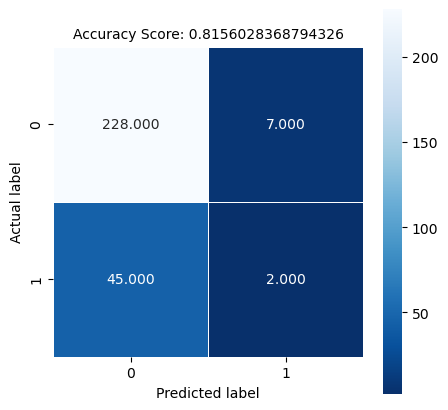

In [32]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

# predict
y_pred = knn.predict(X_test)

# accuracy score
score = knn.score(X_test, y_test)
#print('Accuracy:', score)

# confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)
#print(cm)

plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title('Accuracy Score: {0}'.format(score), size = 10)

In [33]:
## need to handle class imbalance for schizo and healthy subjects!